# Onboarding Challenge

The aim of this notebook is to show how to detect eye blinks and how to filter this artefact from the EEG signal. To achieve this, we will try different ways to analyze the signal.

The following [Udemy course by Mike X Cohen](https://www.udemy.com/signal-processing/) is incredibly useful and is a nice introduction to digital signal processing tools.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from time import strftime, gmtime
from csv import reader
from collections import OrderedDict
import numpy as np
import copy

## Read the prerecorded file
Before doing anything with our data, we want to see what it looks like.

In [66]:
EEG_DATA_FILE_NAME = os.path.join("eeg-records", "eeg_and_eye_blinks_recording.csv")

eeg-records/eeg_and_eye_blinks_recording.csv


In [73]:
def read_eeg_file(csv_file_path):
    eeg_data = OrderedDict()

    with open(csv_file_path, newline='') as eeg_file:
        csv_reader = reader(eeg_file, delimiter=',')
        eeg_data = OrderedDict({key:[] for key in next(csv_reader)})  # Use the headers as key of eeg_data dict
        for samples in csv_reader:
            for i, key in enumerate(eeg_data.keys()):
                eeg_data[key].append(float(samples[i])) # Add the sample to its channel list
    
    return eeg_data

eeg_data = read_eeg_file(EEG_DATA_FILE_NAME)

# This will set the time reference at 0 seconds.
eeg_data['timestamps'] = [float(data) - float(eeg_data['timestamps'][0]) for data in eeg_data['timestamps']]

Now that we have read our EEG data file, we want to plot it to see what it looks like. Note that we don't plot the Right Aux channel since this one was not used in the recording and only have useless noise.

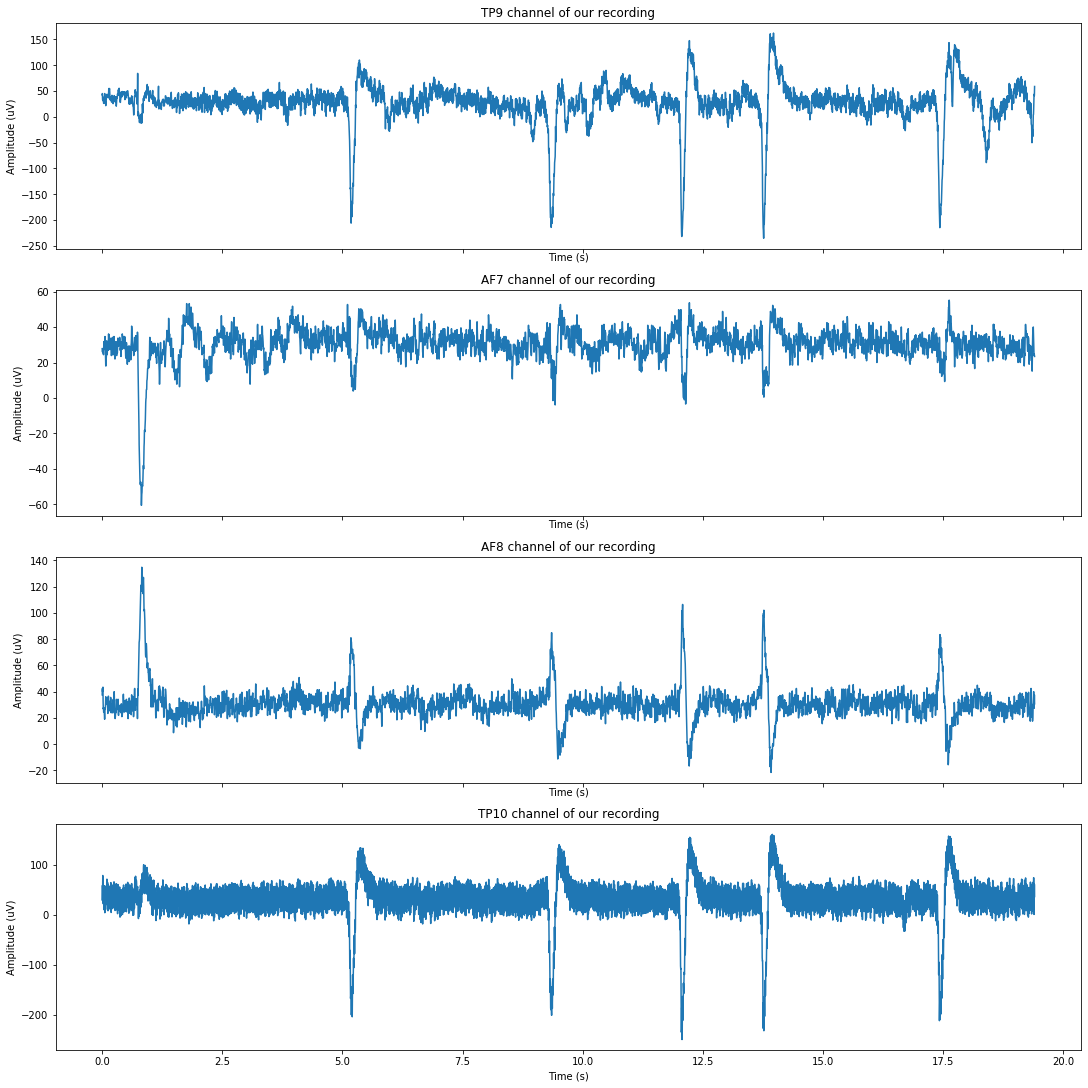

In [74]:
fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True, figsize=[15,15])

# Plot the TP9 channel
axes[0].set_title('TP9 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP9'])

# Plot the AF7 channel
axes[1].set_title('AF7 channel of our recording')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (uV)')
axes[1].plot(eeg_data['timestamps'], eeg_data['AF7'])

# Plot the AF8 channel
axes[2].set_title('AF8 channel of our recording')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (uV)')
axes[2].plot(eeg_data['timestamps'], eeg_data['AF8'])

# Plot the TP10 channel
axes[3].set_title('TP10 channel of our recording')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Amplitude (uV)')
axes[3].plot(eeg_data['timestamps'], eeg_data['TP10'])

# We're not plotting Right Aux channel since we're not using an extra channel.

As we can see, there are some huge spikes in the data. This is caused by the eye blinking that creates current in the electrodes. To understand how the eye blinking affects the EEG signal, we recommand watching [this video](https://www.youtube.com/watch?v=s1GknlqKGYo&list=PLxaiR6teSdjoEZWaDWm28A9QjFN7eguAp&index=4&t=0s). While recording these signals, we made sure to limit the EMG artefacts by not contracting face muscles. Otherwise, this would also have been a factor of signal contamination.

The TP channels seem to have more important spikes in amplitude than the AF channels. This is explained by the position of the reference electrode. Indeed, all EEG signals are the result of the potential at the electrode position minus the potential at the reference position. This means that the noise at the reference electrode is cancelled in all electrodes. TP spikes are negatives since a high potential is detected on the ref electrode, causing the TP channel to be substracted by a high number.

## Detect eye blinks

To begin, we'll filter the TP10 channel since it has the steepest curves when a blink occurs.

### Doing it the simple way

We can see that a blink artefact corresponds to a steep spike in the signal. For that channel, the amplitude goes down when the eye closes and goes up when it opens. So what we could to do is simply to apply a threshold on the absolute value of the amplitude. To pick the threshold, lets plot an histogram of the amplitude occurences. Then, we will set a threshold for the values we considered uncommon.

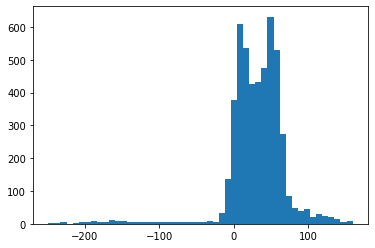

In [5]:
plt.hist(eeg_data['TP10'], 50)
plt.show()

We choose a threshold of 100 uV because we consider that superior amplitude values are uncommon. This is a completely  arbitrary choice based on our observation of the previous histogram.

We then apply the threshold on the amplitude, whereas the absolute value, of the signal. We create a time series with a `1` for every value of amplitude greater than the threshold, and `0` otherwise.

In [76]:
THRESHOLD = 100 # We picked this number based on the previous histogram.
blink_data = [abs(amplitude) > THRESHOLD for amplitude in eeg_data['TP10']]

We then visualize the results of the applied threshold.

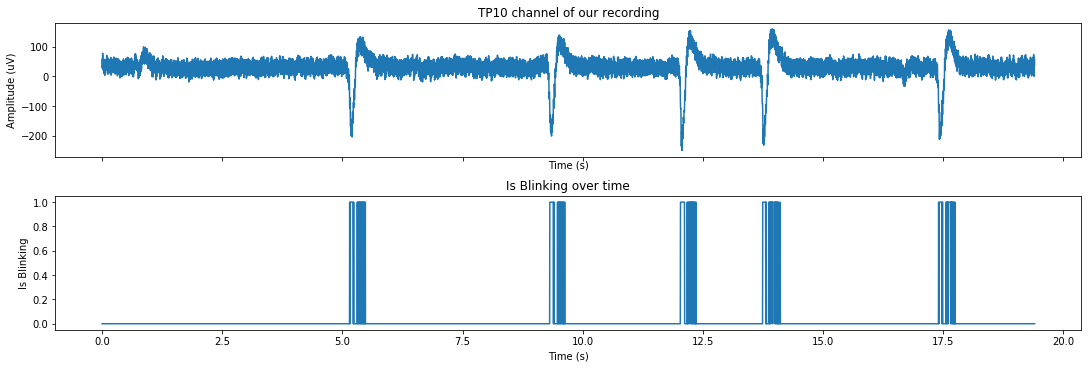

In [77]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP10'])

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_data)

Yay! We indeed detected all the expected artefacts. However, the blink signal presents nasty oscillations since the original time series has its amplitude oscillates around our threshold value.

To remedy this, we can add some debouncing to the signal and ensure that we count only one rising edge for every blink.

In [78]:
DEBOUNCING = 0.1
FREQUENCY = 256
PERIOD = 1/FREQUENCY

rising_edges = []
falling_edges = []

last_value = blink_data[0]
for i, data in enumerate(blink_data):
    if data is not last_value:
        if last_value:
            falling_edges.append(i)
        else:
            rising_edges.append(i)
    last_value = data

for i in falling_edges:
    next_rising_edges = [index for index in rising_edges if index > i]
    if len(next_rising_edges) != 0 and (next_rising_edges[0] - i) * PERIOD < DEBOUNCING:
        for j in range(i, next_rising_edges[0]):
            blink_data[j] = True
 

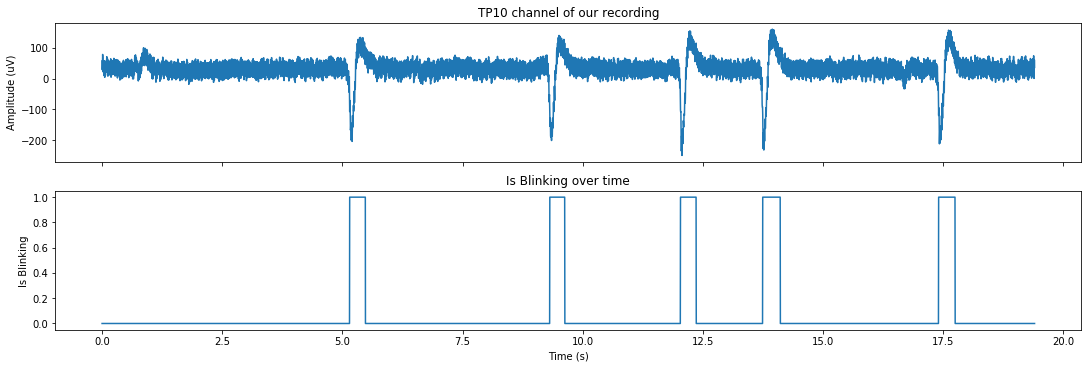

In [79]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP10'])

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_data)

### Some issues with the previous method
The simple threshold value method is good, but requires a human intervention to set the threshold. Indeed, this threshold must be manually set for every recording of data since change in signal amplitude due to blinking can vary a lot (e.g. from subject to another). Also, doing it this way is only valid for signal centered around the y = 0 axis. It is also usual for a signal to have its mean shifted during a recording.

### [TKEO algorithm](https://drive.google.com/open?id=1N9ARGXhnCmY9S7QUc8uIdMRM9L1OF6Ao) before setting threshold
Since the previously used threshold is determined arbitrarily, a better solution would be to normalize the signal and set a treshold that would be valid for signals of different subjects.

One way of acheving this could be to use the TKEO method to put emphasis on data points that have great changes in amplitude. We could then calculate the z-score of a given data point and set a z-score threshold (still a little bit arbitrary but at least the criteria can be automatically set) to detect a blink.

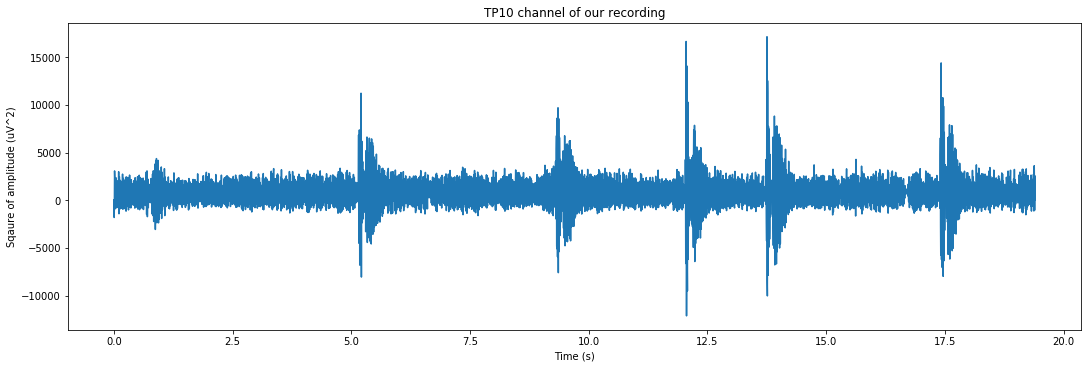

In [10]:
tkeo_eeg_data = copy.deepcopy(eeg_data['TP10'])

# the loop version for interpretability
for i in range(1,len(tkeo_eeg_data)-1):
    tkeo_eeg_data[i] = eeg_data['TP10'][i]**2 - eeg_data['TP10'][i-1]*eeg_data['TP10'][i+1]
    
fig, axes = plt.subplots(1, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes.set_title('TP10 channel of our recording')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Sqaure of amplitude (uV^2)')
axes.plot(eeg_data['timestamps'], tkeo_eeg_data)

In order to compare both signals, we have to put them in the same scale. The original signal has an amplitude in microvolts, whereas the TKEO signal has an amplitude of squared microvolts. We can put them in the same scale by comparing their z-score, meaning we will look at how far the signal is compared to the standard deviation and the mean. The z-score centers the original signal at 0.

The standard deviation and the mean will be calculated from a subpart of the signal that does not contain artefact. We will take the first 4 seconds from the TP10 channel.

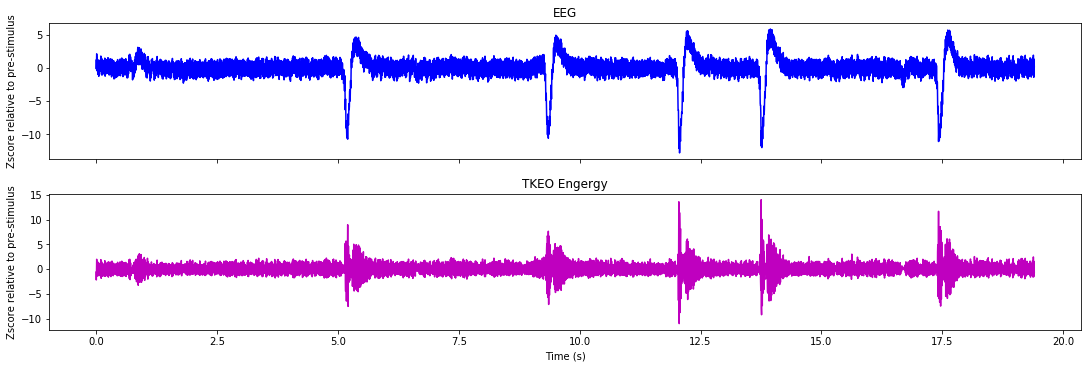

In [52]:
a = 4*FREQUENCY

eeg_mean = np.mean(eeg_data["TP10"][0:int(4*FREQUENCY)])
eeg_std_deviation = np.std(eeg_data["TP10"][0:int(4*FREQUENCY)])

tkeo_eeg_mean = np.mean(tkeo_eeg_data[0:int(4*FREQUENCY)])
tkeo_eeg_std_deviation = np.std(tkeo_eeg_data[0:int(4*FREQUENCY)])

tp10_eeg_data_zscore = (eeg_data["TP10"] - eeg_mean) / eeg_std_deviation
tp10_tkeo_eeg_zscore = (tkeo_eeg_data - tkeo_eeg_mean) / tkeo_eeg_std_deviation

# plot zscored
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])
axes[0].set_title('TP10 channel of our recording')

axes[0].set_title('EEG')
axes[0].set_ylabel('Zscore relative to pre-stimulus')
axes[0].plot(eeg_data['timestamps'], tp10_eeg_data_zscore, 'b')

axes[1].set_title('TKEO Engergy')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Zscore relative to pre-stimulus')
axes[1].plot(eeg_data["timestamps"],tp10_tkeo_eeg_zscore,'m')

As before, the threshold can be determined by looking at the histrogram of the amplitude of the previous plot.

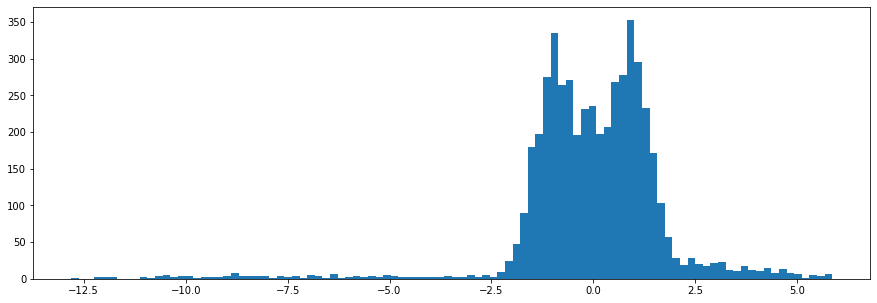

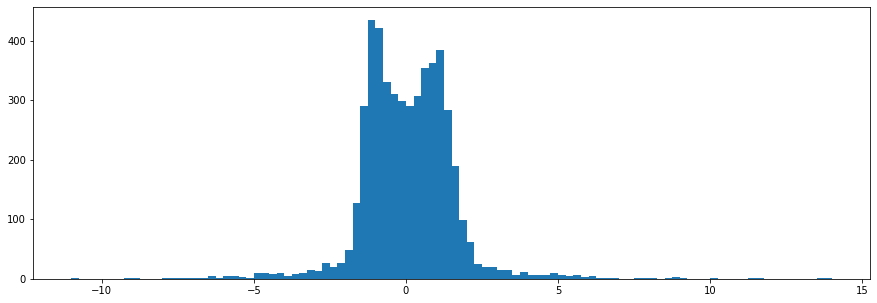

In [60]:
plt.hist(tp10_eeg_data_zscore, 100)
plt.show()

plt.hist(tp10_tkeo_eeg_zscore, 100)
plt.show()

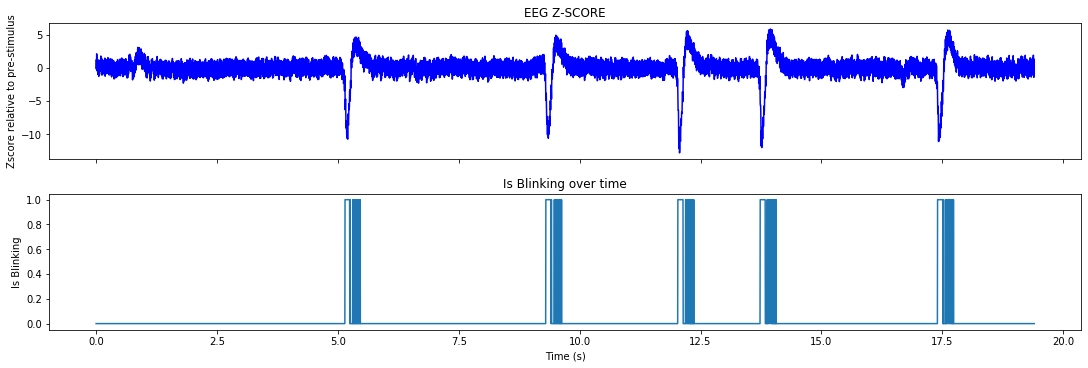

In [58]:
# We want indexes that are superior to a threshold. This is completly a arbitrary value based of our observation of the signal's plot. 
Z_SCORE_THRESHOLD = 3.5 # We picked this number based on the previous histogram.
blink_data = [abs(z_score) > Z_SCORE_THRESHOLD for z_score in tp10_eeg_data_zscore]

fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

axes[0].set_title('EEG Z-SCORE')
axes[0].set_ylabel('Zscore relative to pre-stimulus')
axes[0].plot(eeg_data['timestamps'], tp10_eeg_data_zscore, 'b')

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_data)

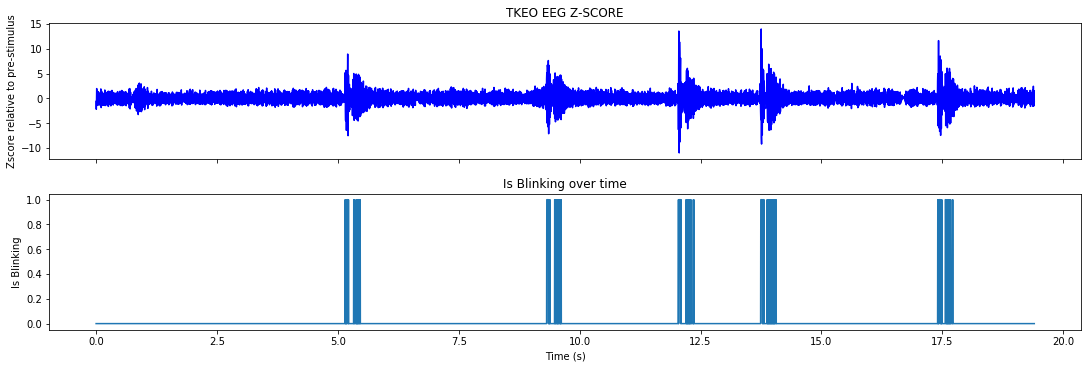

In [64]:
TKEO_Z_SCORE_THRESHOLD = 4 # We picked this number based on the previous histogram.
blink_data = [abs(z_score) > TKEO_Z_SCORE_THRESHOLD for z_score in tp10_tkeo_eeg_zscore]

fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

axes[0].set_title('TKEO EEG Z-SCORE')
axes[0].set_ylabel('Zscore relative to pre-stimulus')
axes[0].plot(eeg_data['timestamps'], tp10_tkeo_eeg_zscore, 'b')

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_data)

# Record an EEG signal

In [ ]:
muses = list_muses()
if len(muses):
    stream_process = Process(target=stream, args=(muses[0]['address'],))
    stream_process.start()

In [ ]:
# view(backend="Qt5Agg") # Use this backend on Linux
view(backend="MacOSX") # Use this backend on MacOS
# view(backend="TkAgg") # Use this backend on Windows

In [ ]:
DURATION = 20  # secs
RECORDING_PATH = os.path.join("eeg-records", "recording-%s.csv" % strftime("%Y-%m-%d-%H.%M.%S", gmtime()))

In [ ]:
recording_process = Process(target=record, args=(DURATION, RECORDING_PATH))
recording_process.start()